### Homework 7

이번 과제에서는 Cointegration를 이용한 Pair Trading 전략과 market long memory에 대해 실습하도록 한다

#### 1. Pair Trading strategy

**1.1 Data Import**

아래의 library를 이용하여 2020년 1월 1일부터 2023년 8월 31일까지의 신한지주(055550)와 KB금융지주(105560)의 시계열 데이터를 import하고, 수익률에 대한 Matrix로 변환하라

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime

In [2]:
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2023, 8, 31)

shinhan = pdr.DataReader("055550", "naver", start_date, end_date).astype(float)
kb = pdr.DataReader("105560", "naver", start_date, end_date).astype(float)

In [3]:
shinhan_ret = np.log(shinhan.Close / shinhan.Close.shift(1)).dropna()
kb_ret = np.log(kb.Close / kb.Close.shift(1)).dropna()

matrix = pd.concat([shinhan_ret, kb_ret], axis = 1)
matrix.columns = ['Shinhan','KB']
matrix

,Shinhan,KB
Date,,
2020-01-03,0.003515,0.012807
2020-01-06,-0.015321,-0.011733
2020-01-07,0.015321,0.008547
2020-01-08,-0.017700,-0.018251
2020-01-09,0.004751,0.007555
...,...,...
2023-08-25,0.004270,-0.013245
2023-08-28,0.009894,0.001903
2023-08-29,0.001405,0.005687


**1.2 Estimate VAR Model**

아래 library를 활용해 신한지주와 KB금융지주간 $\mathrm{VAR}(1)$모형을 추정하라

In [4]:
from statsmodels.tsa.api import VAR

In [5]:
model = VAR(matrix)
results = model.fit(1, trend = 'c')
results.summary()

/Users/junghunlee/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 04, Oct, 2023
Time:                     01:59:18
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -16.6099
Nobs:                     906.000    HQIC:                  -16.6296
Log likelihood:           4973.60    FPE:                5.92348e-08
AIC:                     -16.6418    Det(Omega_mle):     5.88445e-08
--------------------------------------------------------------------
Results for equation Shinhan
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             -0.000207         0.000646           -0.321           0.749
L1.Shinhan        -0.018347         0.058639           -0.313           0.754
L1.KB             -0.002342         0.051712           -0.045         

**1.3 Cointegration Test**

주어진 수익률 행렬에 대해서 아래의 library를 사용해 공적분 검증을 시행하라. 두 시계열은 공적분 관계에 있는가? 검정 결과는 어떤 insight를 도출하는가?

In [6]:
from statsmodels.tsa.stattools import coint

In [7]:
score, p_value, _ = coint(matrix['KB'], matrix['Shinhan'])
print('Correlation : %.4f' % matrix['KB'].corr(matrix['Shinhan']))
print('Cointegration test p-value : %.4f' % p_value)
print('Cointegration test score : %.4f'  % score)

Correlation : 0.8230
Cointegration test p-value : 0.0000
Cointegration test score : -19.9941


Cointegration test 결과 p-value가 0에 한없이 가까움으로 두 자산은 공적분 관계에 있다. 이 결과로 장기적으로 두 자산이 서로 유의한 관계가 있다는 것을 알 수 있다

**1.4 Spread**

두 자산간 ratio는 다음과 같이 계산 가능하다

$$\mathrm{Asset~ratio} = \frac{P_a}{P_b}$$

여기서 $P_a$는 자산 a의 가격, $P_b$는 자산 b의 가격을 의미한다. Asset ratio의 5일, 60일 Maving Average를 계산하여 다음과 같은 방법으로 spread를 추정할 수 있다

$$\mathrm{std} = \mathrm{MA}(\mathrm{std}(60))$$
$$\mathrm{Spread} = \frac{\mathrm{MA}(5) - \mathrm{MA}(60)}{\mathrm{std}}$$

(단, std의 경우 rolling을 이용해 추정하면 59번째 값부터 값을 가지기 때문에 spread는 59번째 기간부터 슬라이싱하여 사용하면 된다)

신한지주와 KB금융지주의 수익률을 이용해 두 자산간 spread를 계산하고 적절한 방법을 이용해 시각화하라

In [8]:
import matplotlib.pyplot as plt

In [9]:
ratio = kb.Close / shinhan.Close
ma5 = ratio.rolling(window = 5, center = False).mean()
ma60 = ratio.rolling(window = 60, center = False).mean()
std = ratio.rolling(window = 60, center = False).std()

spread = (ma5[59:] - ma60[59:]) / std[59:]

Text(0.5, 1.0, 'Maving Average Line')

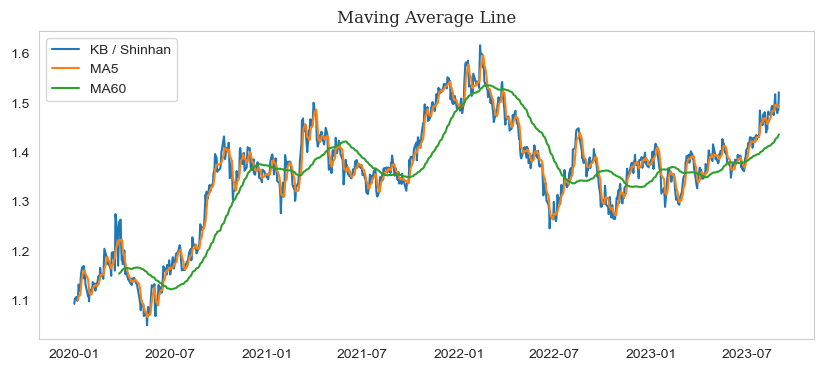

In [10]:
plt.figure(figsize = (10,4))
plt.plot(ratio, label = 'KB / Shinhan')
plt.plot(ma5, label = 'MA5')
plt.plot(ma60, label = 'MA60')
plt.grid(False)
plt.legend()
plt.title('Maving Average Line', fontsize = 12, fontfamily = 'Serif')

Text(0.5, 1.0, 'Asset Spread (KB - Shinhan)')

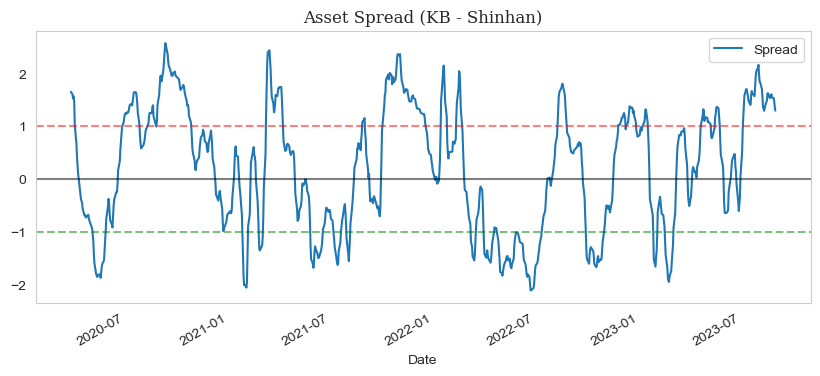

In [11]:
plt.figure(figsize = (10,4))
spread.plot(label = 'Spread')
plt.legend()
plt.grid(False)
plt.axhline(0, color = 'black', alpha = 0.5)
plt.axhline(1.0, color = 'red', linestyle = '--', alpha = 0.5)
plt.axhline(-1.0, color = 'green', linestyle = '--', alpha = 0.5)
plt.title('Asset Spread (KB - Shinhan)', fontsize = 12, fontfamily = 'Serif')

**1.5 Trading Strategy**

$\mathrm{Asset~ratio} = \frac{P_a}{P_b}$일 때, Spread가 -1 이하로 떨어지면 a자산을 매수 & b자산을 매도하는 매수전략을, 1 이상으로 상승하면 a자산 매도 & b 자산을 매수하는 매도전략을 취한다

pandas dataframe을 이용해 신한지주와 KB금융지주의 수익률과 spread, betting side으로 이뤄진 matrix를 생성하라

(hint : betting side는 전략의 방향을 결정하는 것으로, 1이면 매수, 0이면 유보, -1이면 매도로 표현한다)

In [12]:
bet = pd.concat([kb_ret, shinhan_ret, spread], axis = 1).dropna()
bet.columns = ['KB','Shinhan','spread']
bet['betting side'] = 0
bet.loc[bet['spread'] >= 1, 'betting side'] = -1
bet.loc[bet['spread'] <= -1, 'betting side'] = 1
bet

,KB,Shinhan,spread,betting side
Date,,,,
2020-03-27,0.083078,0.037673,1.655239,-1
2020-03-30,-0.028371,-0.032203,1.607559,-1
2020-03-31,-0.005772,0.039221,1.523859,-1
2020-04-01,-0.089250,-0.066872,1.566943,-1
2020-04-02,0.003160,0.000000,1.466970,-1
...,...,...,...,...
2023-08-25,-0.013245,0.004270,1.543281,-1
2023-08-28,0.001903,0.009894,1.537037,-1
2023-08-29,0.005687,0.001405,1.468357,-1


Text(0.5, 1.0, 'Betting Side')

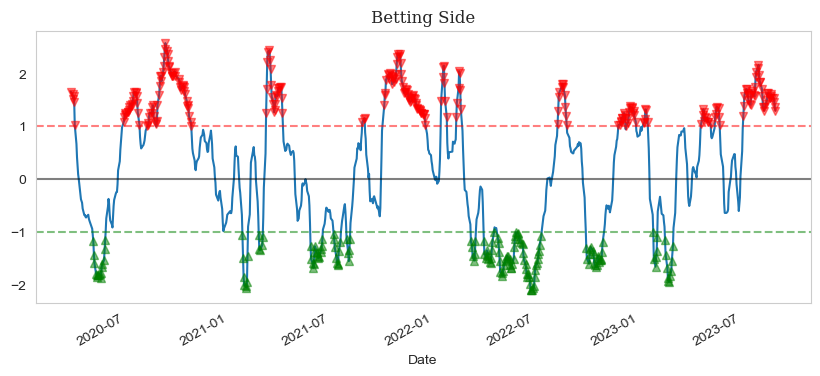

In [13]:
plt.figure(figsize = (10,4))
bet['spread'].plot(label = 'Spread')
plt.axhline(0, color = 'black', alpha = 0.5)
plt.axhline(1.0, color = 'red', linestyle = '--', alpha = 0.5)
plt.axhline(-1.0, color = 'green', linestyle = '--', alpha = 0.5)

bet['spread'][bet['betting side'] == 1].plot(color = 'g', linestyle = 'None', marker = '^', alpha = 0.5)
bet['spread'][bet['betting side'] == -1].plot(color = 'r', linestyle = 'None', marker = 'v', alpha = 0.5)
plt.grid(False)
plt.title('Betting Side', fontsize = 12, fontfamily = 'Serif')

#### 7. Backtesting

행렬에 backtest column을 추가하고 적절한 방법을 사용하여 성과를 Backtesting하라

In [14]:
bet['backtest'] = (-bet.KB + bet.Shinhan) * bet['betting side']
bet

,KB,Shinhan,spread,betting side,backtest
Date,,,,,
2020-03-27,0.083078,0.037673,1.655239,-1,0.045405
2020-03-30,-0.028371,-0.032203,1.607559,-1,0.003832
2020-03-31,-0.005772,0.039221,1.523859,-1,-0.044993
2020-04-01,-0.089250,-0.066872,1.566943,-1,-0.022378
2020-04-02,0.003160,0.000000,1.466970,-1,0.003160
...,...,...,...,...,...
2023-08-25,-0.013245,0.004270,1.543281,-1,-0.017516
2023-08-28,0.001903,0.009894,1.537037,-1,-0.007991
2023-08-29,0.005687,0.001405,1.468357,-1,0.004282


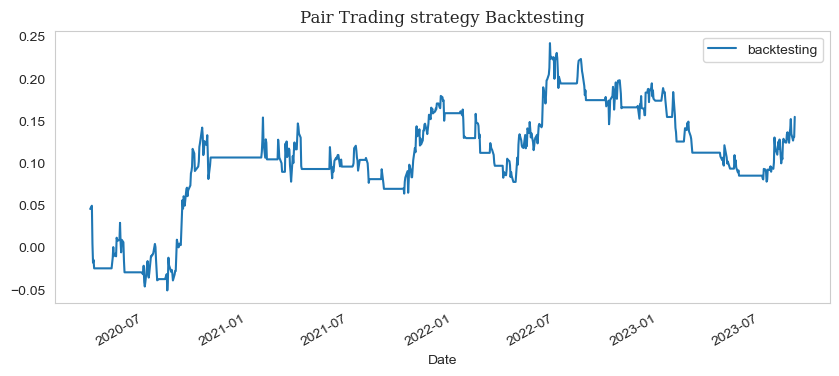

In [15]:
bet['backtest'].cumsum().plot(figsize = (10,4), label = 'backtesting')
plt.legend()
plt.grid(False)
plt.title('Pair Trading strategy Backtesting', fontsize = 12, fontfamily = 'Serif')
plt.show()

#### 2. Market Long Memory

pandas-datareader와 yfinance library를 이용하여 2000년 1월 1일부터 2023년 8월 31일까지의 Samsung Electronics와 IBM주가의 가격 시계열을 가져오라. 두 자산 시계열을 닫힌구간 [0,2]까지 0.1구간별로 차분계수 $d$를 검정하여 Augmented Dickey Fuller test 값이 유의수준 5%(신뢰구간 95%)를 통과하는 최소의 차분계수를 구하여라. 두 자산의 $d$의 값은 어떻게 나오는가? 이를 통해 두 자산 중 어떤 자산의 시계열이 더욱 효율적 시장이라 말할 수 있는가?

In [16]:
import yfinance as yf

start_date = '2000-01-01'
end_date = '2023-09-01'

ibm = yf.download('IBM', start = start_date, end = end_date).iloc[:,[1,3]]

[*********************100%%**********************]  1 of 1 completed


In [17]:
samsung = pdr.DataReader("005930", "naver", start_date, end_date).astype(int).iloc[:,[1,3]]

In [18]:
import IntegratedSeries as IS
import statsmodels.api as sm

def calculate_difference(df : pd.DataFrame, end = 1, numbers = 11) :
    cols = ['adfStat','pVal','lags','nObs','95% conf', 'corr']
    out = pd.DataFrame(columns = cols)
    for d in np.linspace(0, end, numbers):
        try:
            df1 = np.log(df).dropna()
            df2 = IS.fracDiff(df1, d, thres = 1e-5)
            corr = np.corrcoef(df1.loc[df2.index, 'Close'], df2['Close'])[0,1]
            df2 = sm.tsa.stattools.adfuller(df2['Close'], maxlag = 1, regression = 'c', autolag = None)
            out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + [corr]
        except Exception as e:
            print(f'd: {d}, error: {e}')
            continue
    return out

In [19]:
ibm_d = calculate_difference(ibm)

d: 0.1, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.2, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors


In [20]:
samsung_d = calculate_difference(samsung)

/Users/junghunlee/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/junghunlee/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/junghunlee/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/junghunlee/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/junghunlee/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  re

d: 0.1, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.2, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors


/Users/junghunlee/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/junghunlee/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,adfStat,pVal,lags,nObs,95% conf,corr
0.0,-2.119683,2.366741e-01,1.0,5951.0,-2.862026,1.000000
0.3,0.083268,9.649000e-01,1.0,4.0,-4.474365,0.788788
0.4,-0.749808,8.334230e-01,1.0,12.0,-3.154972,0.915110
0.5,-1.981908,2.945616e-01,1.0,30.0,-2.964071,0.288584
0.6,-3.844360,2.484707e-03,1.0,78.0,-2.899375,0.486764
0.7,-6.644938,5.294647e-09,1.0,214.0,-2.875143,0.379660
0.8,-14.230225,1.601298e-26,1.0,643.0,-2.866045,0.244651
0.9,-28.985869,0.000000e+00,1.0,2085.0,-2.862927,0.109863
1.0,-55.650350,0.000000e+00,1.0,5950.0,-2.862026,0.029852


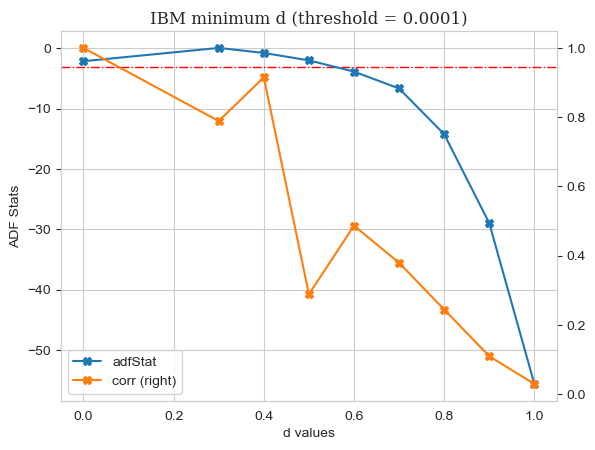

In [21]:
f,ax = plt.subplots()
ax.axhline(ibm_d['95% conf'].mean(), lw = 1, color = 'r', ls = '-.')
ibm_d[['adfStat', 'corr']].plot(ax = ax, marker = 'X', secondary_y = 'corr')
ax.set_title('IBM minimum d (threshold = 0.0001)', fontsize = 12, fontfamily = 'Serif')
ax.set_xlabel('d values')
ax.set_ylabel('ADF Stats');
display(ibm_d)

,adfStat,pVal,lags,nObs,95% conf,corr
0.0,-1.010031,7.495882e-01,1.0,5842.0,-2.862035,1.000000
0.3,1.867349,9.984736e-01,1.0,4.0,-4.474365,0.995918
0.4,-0.446648,9.020141e-01,1.0,11.0,-3.189369,0.982062
0.5,-2.196878,2.073807e-01,1.0,29.0,-2.967882,0.542980
0.6,-3.625534,5.291216e-03,1.0,75.0,-2.900925,0.402038
0.7,-8.324641,3.497196e-13,1.0,207.0,-2.875606,0.261571
0.8,-15.445975,2.824625e-28,1.0,622.0,-2.866198,0.136639
0.9,-29.305473,0.000000e+00,1.0,2024.0,-2.862969,0.019139
1.0,-57.449160,0.000000e+00,1.0,5841.0,-2.862035,0.013310


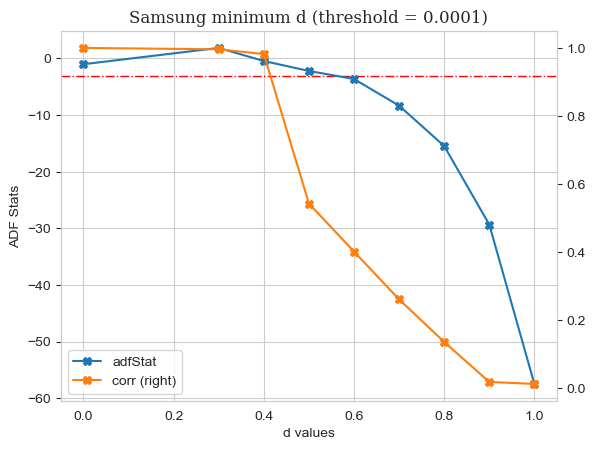

In [22]:
f,ax = plt.subplots()
ax.axhline(samsung_d['95% conf'].mean(), lw = 1, color = 'r', ls = '-.')
samsung_d[['adfStat', 'corr']].plot(ax = ax, marker = 'X', secondary_y = 'corr')
ax.set_title('Samsung minimum d (threshold = 0.0001)', fontsize = 12, fontfamily = 'Serif')
ax.set_xlabel('d values')
ax.set_ylabel('ADF Stats');
display(samsung_d)

두 자산 모두 ADF검정을 충족하는 최소의 차분계수가 0.6이므로, 어떤 자산이 더 효율적이라고 단정짓기는 힘들다